In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import math
from keras.layers import LSTM, Bidirectional, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras import callbacks
import pickle


In [13]:
PATH = r"../../Data/completeLoad.csv"
df = pd.read_csv(PATH)
temp = df.set_index(['zone_id', 'year', 'month', 'day'])
colname_to_int = {}
for i in list(temp.columns):
    colname_to_int[i] = int(i[1:])

temp = temp.rename(columns=colname_to_int)
temp = temp.stack()
temp = temp.unstack(level=0)
temp.columns.names = [None]
temp.index.names = [None, None, None, None]
df_zone = temp
temp.head(2)

1         2         3      4       5         6         7   \
2004 1 1 1  16853.0  126259.0  136233.0  484.0  6829.0  133088.0  136233.0   
         2  16450.0  123313.0  133055.0  457.0  6596.0  129909.0  133055.0   

                8        9        10       11        12       13       14  \
2004 1 1 1  3124.0  75243.0  23339.0  90700.0  118378.0  20673.0  21791.0   
         2  2956.0  67368.0  22100.0  86699.0  112480.0  19666.0  21400.0   

                 15       16       17        18       19       20  
2004 1 1 1  65970.0  28752.0  30645.0  200946.0  82298.0  79830.0  
         2  64600.0  27851.0  30461.0  195835.0  79827.0  77429.0

## Naive predictors

In [10]:
def get_naive_week_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0:24*7], Y[0:-24*7])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

def get_naive_day_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0:24], Y[0:-24])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

def get_naive_hour_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0, :].reshape(1, -1), Y[0:-1])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

mse_train_naive_hour, train_predict_naive_hour = get_naive_hour_predict_and_score_multi(train_X, train_Y)
mse_test_naive_hour, test_predict_naive_hour = get_naive_hour_predict_and_score_multi(test_X, test_Y)
mse_train_naive_day, train_predict_naive_day = get_naive_day_predict_and_score_multi(train_X, train_Y)
mse_test_naive_day, test_predict_naive_day = get_naive_day_predict_and_score_multi(test_X, test_Y)
mse_train_naive_week, train_predict_naive_week = get_naive_week_predict_and_score_multi(train_X, train_Y)
mse_test_naive_week, test_predict_naive_week = get_naive_week_predict_and_score_multi(test_X, test_Y)

print("(Naive -1 hour) Training data error: %.2f MSE" % mse_train_naive_hour)
print("(Naive -1 hour) Test data error: %.2f MSE" % mse_test_naive_hour)
print("(Naive -1 day) Training data error: %.2f MSE" % mse_train_naive_day)
print("(Naive -1 day) Test data error: %.2f MSE" % mse_test_naive_day)
print("(Naive -1 week) Training data error: %.2f MSE" % mse_train_naive_week)
print("(Naive -1 week) Test data error: %.2f MSE" % mse_test_naive_week)

NameError: name 'train_X' is not defined

In [11]:
def get_naive_week_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0:24*7], Y[0:-24*7])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, pred)

def get_naive_day_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0:24], Y[0:-24])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, pred)

def get_naive_hour_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0, :].reshape(1, -1), Y[0:-1])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, pred)

mse_train_naive_hour, train_predict_naive_hour = get_naive_hour_predict_and_score_multi(train_X, train_Y)
mse_test_naive_hour, test_predict_naive_hour = get_naive_hour_predict_and_score_multi(test_X, test_Y)
mse_train_naive_day, train_predict_naive_day = get_naive_day_predict_and_score_multi(train_X, train_Y)
mse_test_naive_day, test_predict_naive_day = get_naive_day_predict_and_score_multi(test_X, test_Y)
mse_train_naive_week, train_predict_naive_week = get_naive_week_predict_and_score_multi(train_X, train_Y)
mse_test_naive_week, test_predict_naive_week = get_naive_week_predict_and_score_multi(test_X, test_Y)

print("(Naive -1 hour) Training data error: %.2f MSE" % mse_train_naive_hour)
print("(Naive -1 hour) Test data error: %.2f MSE" % mse_test_naive_hour)
print("(Naive -1 day) Training data error: %.2f MSE" % mse_train_naive_day)
print("(Naive -1 day) Test data error: %.2f MSE" % mse_test_naive_day)
print("(Naive -1 week) Training data error: %.2f MSE" % mse_train_naive_week)
print("(Naive -1 week) Test data error: %.2f MSE" % mse_test_naive_week)

NameError: name 'train_X' is not defined

## LSTM 

In [94]:
# use data for zone 1.
data = df_zone[1].values.reshape(-1, 1)

# normalize data with min max normalization.
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data)

# Using 80% of data for training, 20% for validation.
TRAINING_PERCENT = 0.80

train_size = int(len(dataset) * TRAINING_PERCENT)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

Number of samples training set: 31660
Number of samples test set: 7916


In [95]:
def create_dataset_nstep(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - nstep - 1):
        sample = dataset[i:(i + window_size), 0]
        data_x.append(sample)
        data_y.append(dataset[(i + window_size):(i + window_size + nstep), 0])
    return(np.array(data_x), np.array(data_y))

In [104]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 50
nstep = 1
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26866 samples, validate on 4742 samples
Epoch 1/100
 - 8s - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0312 - val_loss: 6.0377e-04 - val_mean_squared_error: 6.0377e-04 - val_mean_absolute_error: 0.0190
Epoch 2/100
 - 3s - loss: 3.3333e-04 - mean_squared_error: 3.3333e-04 - mean_absolute_error: 0.0139 - val_loss: 2.8379e-04 - val_mean_squared_error: 2.8379e-04 - val_mean_absolute_error: 0.0126
Epoch 3/100
 - 3s - loss: 1.9561e-04 - mean_squared_error: 1.9561e-04 - mean_absolute_error: 0.0105 - val_loss: 2.0449e-04 - val_mean_squared_error: 2.0449e-04 - val_mean_absolute_error: 0.0103
Epoch 4/100
 - 3s - loss: 1.3714e-04 - mean_squared_error: 1.3714e-04 - mean_absolute_error: 0.0087 - val_loss: 1.3369e-04 - val_mean_squared_error: 1.3369e-04 - val_mean_absolute_error: 0.0082
Epoch 5/100
 - 3s - loss: 1.0398e-04 - mean_squared_error: 1.0398e-04 - mean_absolute_error: 0.0075 - val_loss: 1.2689e-04 - val_mean_squared_error: 1.2689e-04 - val_mean_absolute_err

In [100]:
vanilla_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 20)                5680      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 21        
Total params: 5,701
Trainable params: 5,701
Non-trainable params: 0
_________________________________________________________________


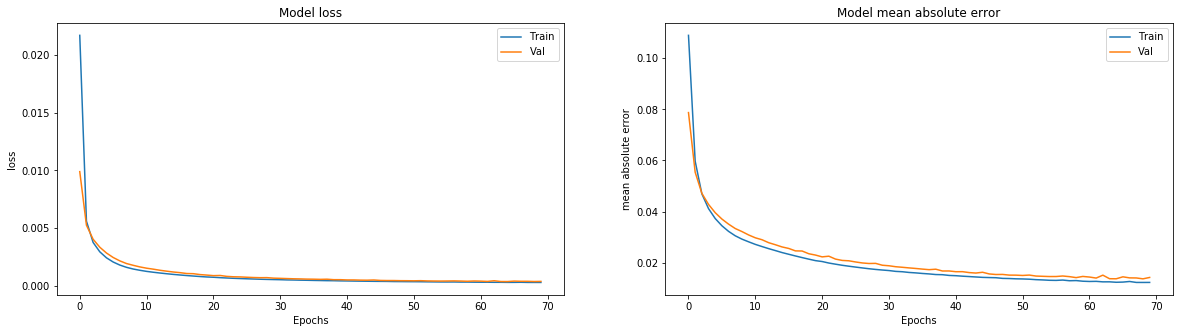

In [101]:
metrics = [['loss', 'val_loss'], ['mean_absolute_error', 
           'val_mean_absolute_error']]

plt.figure(figsize = (20, 5))
for i, x in enumerate(metrics):
    plt.subplot(1, 2, i+1)
    plt.plot(history.history[x[0]])
    plt.plot(history.history[x[1]])
    plt.legend(['Train', 'Val'], loc='best')
    string_metric = (' ').join(x[0].split('_'))
    plt.xlabel("Epochs")
    plt.title('Model {}'.format(string_metric))
    plt.ylabel(string_metric)
plt.show()

In [107]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 100
nstep = 1
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26824 samples, validate on 4734 samples
Epoch 1/100
 - 15s - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0353 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0267
Epoch 2/100
 - 4s - loss: 7.0284e-04 - mean_squared_error: 7.0284e-04 - mean_absolute_error: 0.0199 - val_loss: 6.4824e-04 - val_mean_squared_error: 6.4824e-04 - val_mean_absolute_error: 0.0192
Epoch 3/100
 - 4s - loss: 5.3343e-04 - mean_squared_error: 5.3343e-04 - mean_absolute_error: 0.0172 - val_loss: 5.2700e-04 - val_mean_squared_error: 5.2700e-04 - val_mean_absolute_error: 0.0171
Epoch 4/100
 - 4s - loss: 4.5272e-04 - mean_squared_error: 4.5272e-04 - mean_absolute_error: 0.0157 - val_loss: 7.0722e-04 - val_mean_squared_error: 7.0722e-04 - val_mean_absolute_error: 0.0209
Epoch 5/100
 - 4s - loss: 4.1717e-04 - mean_squared_error: 4.1717e-04 - mean_absolute_error: 0.0151 - val_loss: 4.0633e-04 - val_mean_squared_error: 4.0633e-04 - val_mean_absolute_error: 0.0

In [108]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 1000
nstep = 1
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26059 samples, validate on 4599 samples
Epoch 1/100
 - 27s - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0457 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0329
Epoch 2/100
 - 14s - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0291 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0257
Epoch 3/100
 - 13s - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0245 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0272
Epoch 4/100
 - 14s - loss: 8.5775e-04 - mean_squared_error: 8.5775e-04 - mean_absolute_error: 0.0223 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0330
Epoch 5/100
 - 13s - loss: 7.8668e-04 - mean_squared_error: 7.8668e-04 - mean_absolute_error: 0.0213 - val_loss: 9.1250e-04 - val_mean_squared_error: 9.1250e-04 - val_mean_absolute_error: 0.0227
Epoch 6/100
 - 14s - loss: 7.144

In [109]:
window_size = 50
nstep = 24
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26847 samples, validate on 4738 samples
Epoch 1/100
 - 17s - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0730 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0612
Epoch 2/100
 - 4s - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0514 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0583
Epoch 3/100
 - 3s - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0497 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0570
Epoch 4/100
 - 4s - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0490 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0566
Epoch 5/100
 - 4s - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0484 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0557
Epoch 6/100
 - 4s - loss: 0.0044 - mean_squared_error: 0.004

In [110]:
window_size = 200
nstep = 24
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26719 samples, validate on 4716 samples
Epoch 1/100
 - 18s - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0660 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0596
Epoch 2/100
 - 4s - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0495 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0567
Epoch 3/100
 - 4s - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0481 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0562
Epoch 4/100
 - 4s - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0471 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0557
Epoch 5/100
 - 4s - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0465 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0539
Epoch 6/100
 - 4s - loss: 0.0040 - mean_squared_error: 0.004

In [111]:
window_size = 1000
nstep = 24
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26039 samples, validate on 4596 samples
Epoch 1/100
 - 29s - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0628 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0596
Epoch 2/100
 - 13s - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0507 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0581
Epoch 3/100
 - 14s - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0490 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0572
Epoch 4/100
 - 13s - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0483 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0551
Epoch 5/100
 - 14s - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0472 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0558
Epoch 6/100
 - 17s - loss: 0.0039 - mean_squared_error: 

In [112]:
window_size = 200
nstep = 24*7
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26597 samples, validate on 4694 samples
Epoch 1/100
 - 19s - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0840 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0797
Epoch 2/100
 - 4s - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0683 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0796
Epoch 3/100
 - 4s - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0678 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0801
Epoch 4/100
 - 5s - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0674 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0793
Epoch 5/100
 - 5s - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0672 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0795
Epoch 6/100
 - 4s - loss: 0.0081 - mean_squared_error: 0.008

In [113]:
window_size = 500
nstep = 24*7
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26342 samples, validate on 4649 samples
Epoch 1/100
 - 31s - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0827 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0800
Epoch 2/100
 - 9s - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0679 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0787
Epoch 3/100
 - 16s - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0674 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0790
Epoch 4/100
 - 15s - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0670 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0790
Epoch 5/100
 - 11s - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0665 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0789
Epoch 6/100
 - 11s - loss: 0.0079 - mean_squared_error: 0

In [114]:
window_size = 1000
nstep = 24*7
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 25917 samples, validate on 4574 samples
Epoch 1/100
 - 29s - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0819 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0780
Epoch 2/100
 - 15s - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0676 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0785
Epoch 3/100
 - 15s - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0665 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0776
Epoch 4/100
 - 14s - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0659 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0803
Epoch 5/100
 - 16s - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0653 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0800
Epoch 6/100
 - 14s - loss: 0.0074 - mean_squared_error: 

## Bidirectional

In [103]:
def create_dataset_nstep_bidir(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - nstep - 1):
        ws_2 = int(window_size/2)
        s1 = dataset[i:(i + ws_2), 0]
        s2 = dataset[(i + ws_2 + nstep):(i + window_size + nstep), 0]
        data_x.append(np.concatenate((s1, s2)))
        data_y.append(dataset[(i + ws_2):(i + ws_2 + nstep), 0])
    return(np.array(data_x), np.array(data_y))

In [79]:
def create_dataset_nstep_bidir(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - nstep - 1):
        ws_2 = int(window_size/2)
        s1 = dataset[i:(i + ws_2), 0]
        s2 = dataset[(i + ws_2 + nstep):(i + window_size + nstep), 0]
        data_x.append(np.concatenate((s1, s2)))
        data_y.append(dataset[(i + ws_2):(i + ws_2 + nstep), 0])
    return(np.array(data_x), np.array(data_y))

window_size = 50
nstep = 1
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [115]:
def create_model_nstep_bidir(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(Bidirectional(LSTM(20, input_shape = (1, window_size))))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 50
nstep = 1
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26866 samples, validate on 4742 samples
Epoch 1/100
 - 24s - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0349 - val_loss: 9.3123e-04 - val_mean_squared_error: 9.3123e-04 - val_mean_absolute_error: 0.0231
Epoch 2/100
 - 5s - loss: 6.1612e-04 - mean_squared_error: 6.1612e-04 - mean_absolute_error: 0.0185 - val_loss: 6.6360e-04 - val_mean_squared_error: 6.6360e-04 - val_mean_absolute_error: 0.0197
Epoch 3/100
 - 5s - loss: 4.6358e-04 - mean_squared_error: 4.6358e-04 - mean_absolute_error: 0.0158 - val_loss: 5.1465e-04 - val_mean_squared_error: 5.1465e-04 - val_mean_absolute_error: 0.0166
Epoch 4/100
 - 5s - loss: 4.1431e-04 - mean_squared_error: 4.1431e-04 - mean_absolute_error: 0.0149 - val_loss: 4.3151e-04 - val_mean_squared_error: 4.3151e-04 - val_mean_absolute_error: 0.0148
Epoch 5/100
 - 4s - loss: 3.6583e-04 - mean_squared_error: 3.6583e-04 - mean_absolute_error: 0.0139 - val_loss: 4.1994e-04 - val_mean_squared_error: 4.1994e-04 - val_mean_absolute_er

In [116]:
def create_model_nstep_bidir(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(Bidirectional(LSTM(20, input_shape = (1, window_size))))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 100
nstep = 1
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26824 samples, validate on 4734 samples
Epoch 1/100
 - 22s - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0360 - val_loss: 9.4662e-04 - val_mean_squared_error: 9.4662e-04 - val_mean_absolute_error: 0.0232
Epoch 2/100
 - 6s - loss: 7.2613e-04 - mean_squared_error: 7.2613e-04 - mean_absolute_error: 0.0202 - val_loss: 7.0665e-04 - val_mean_squared_error: 7.0665e-04 - val_mean_absolute_error: 0.0206
Epoch 3/100
 - 7s - loss: 5.4685e-04 - mean_squared_error: 5.4685e-04 - mean_absolute_error: 0.0175 - val_loss: 5.2715e-04 - val_mean_squared_error: 5.2715e-04 - val_mean_absolute_error: 0.0170
Epoch 4/100
 - 6s - loss: 4.8682e-04 - mean_squared_error: 4.8682e-04 - mean_absolute_error: 0.0164 - val_loss: 4.6533e-04 - val_mean_squared_error: 4.6533e-04 - val_mean_absolute_error: 0.0158
Epoch 5/100
 - 7s - loss: 4.1990e-04 - mean_squared_error: 4.1990e-04 - mean_absolute_error: 0.0152 - val_loss: 4.9523e-04 - val_mean_squared_error: 4.9523e-04 - val_mean_absolute_er

In [118]:
def create_model_nstep_bidir(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(Bidirectional(LSTM(20, input_shape = (1, window_size))))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 50
nstep = 24
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26847 samples, validate on 4738 samples
Epoch 1/100
 - 27s - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0661 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0587
Epoch 2/100
 - 4s - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0502 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0572
Epoch 3/100
 - 4s - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0490 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0567
Epoch 4/100
 - 5s - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0485 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0556
Epoch 5/100
 - 4s - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0480 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0555
Epoch 6/100
 - 5s - loss: 0.0044 - mean_squared_error: 0.004

In [119]:
def create_model_nstep_bidir(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(Bidirectional(LSTM(20, input_shape = (1, window_size))))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 200
nstep = 24
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26719 samples, validate on 4716 samples
Epoch 1/100
 - 25s - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0612 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0575
Epoch 2/100
 - 7s - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0487 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0569
Epoch 3/100
 - 8s - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0473 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0547
Epoch 4/100
 - 8s - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0465 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0546
Epoch 5/100
 - 8s - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0462 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0535
Epoch 6/100
 - 7s - loss: 0.0039 - mean_squared_error: 0.003

In [120]:
def create_model_nstep_bidir(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(Bidirectional(LSTM(20, input_shape = (1, window_size))))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 200
nstep = 24*7
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26597 samples, validate on 4694 samples
Epoch 1/100
 - 28s - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0781 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0794
Epoch 2/100
 - 8s - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0677 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0796
Epoch 3/100
 - 9s - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0672 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0793
Epoch 4/100
 - 8s - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0668 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0815
Epoch 5/100
 - 9s - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0666 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0809
Epoch 6/100
 - 8s - loss: 0.0080 - mean_squared_error: 0.008

In [121]:
def create_model_nstep_bidir(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(Bidirectional(LSTM(20, input_shape = (1, window_size))))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 500
nstep = 24*7
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26342 samples, validate on 4649 samples
Epoch 1/100
 - 37s - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0777 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0790
Epoch 2/100
 - 20s - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0676 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0791
Epoch 3/100
 - 20s - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0670 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0794
Epoch 4/100
 - 19s - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0665 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0784
Epoch 5/100
 - 18s - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0657 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0792
Epoch 6/100
 - 20s - loss: 0.0077 - mean_squared_error: 

In [131]:

window_size = 50
nstep = 1
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26866 samples, validate on 4742 samples
Epoch 1/100
 - 35s - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0216 - val_loss: 3.1007e-04 - val_mean_squared_error: 3.1007e-04 - val_mean_absolute_error: 0.0133
Epoch 2/100
 - 7s - loss: 1.9599e-04 - mean_squared_error: 1.9599e-04 - mean_absolute_error: 0.0105 - val_loss: 2.6108e-04 - val_mean_squared_error: 2.6108e-04 - val_mean_absolute_error: 0.0123
Epoch 3/100
 - 7s - loss: 1.3397e-04 - mean_squared_error: 1.3397e-04 - mean_absolute_error: 0.0087 - val_loss: 1.3561e-04 - val_mean_squared_error: 1.3561e-04 - val_mean_absolute_error: 0.0083
Epoch 4/100
 - 7s - loss: 1.0455e-04 - mean_squared_error: 1.0455e-04 - mean_absolute_error: 0.0075 - val_loss: 1.0703e-04 - val_mean_squared_error: 1.0703e-04 - val_mean_absolute_error: 0.0072
Epoch 5/100
 - 7s - loss: 9.1152e-05 - mean_squared_error: 9.1152e-05 - mean_absolute_error: 0.0071 - val_loss: 1.3149e-04 - val_mean_squared_error: 1.3149e-04 - val_mean_absolute_er

In [125]:

window_size = 100
nstep = 1
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26824 samples, validate on 4734 samples
Epoch 1/100
 - 26s - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0237 - val_loss: 3.5814e-04 - val_mean_squared_error: 3.5814e-04 - val_mean_absolute_error: 0.0143
Epoch 2/100
 - 6s - loss: 2.2665e-04 - mean_squared_error: 2.2665e-04 - mean_absolute_error: 0.0112 - val_loss: 2.1280e-04 - val_mean_squared_error: 2.1280e-04 - val_mean_absolute_error: 0.0108
Epoch 3/100
 - 7s - loss: 1.6277e-04 - mean_squared_error: 1.6277e-04 - mean_absolute_error: 0.0095 - val_loss: 1.9647e-04 - val_mean_squared_error: 1.9647e-04 - val_mean_absolute_error: 0.0104
Epoch 4/100
 - 8s - loss: 1.2985e-04 - mean_squared_error: 1.2985e-04 - mean_absolute_error: 0.0084 - val_loss: 1.3444e-04 - val_mean_squared_error: 1.3444e-04 - val_mean_absolute_error: 0.0082
Epoch 5/100
 - 8s - loss: 1.1322e-04 - mean_squared_error: 1.1322e-04 - mean_absolute_error: 0.0079 - val_loss: 1.1486e-04 - val_mean_squared_error: 1.1486e-04 - val_mean_absolute_er

In [132]:

window_size = 50
nstep = 24
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26847 samples, validate on 4738 samples
Epoch 1/100
 - 32s - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0536 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0456
Epoch 2/100
 - 7s - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0373 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0425
Epoch 3/100
 - 6s - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0356 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0407
Epoch 4/100
 - 6s - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0348 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0402
Epoch 5/100
 - 6s - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0342 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0400
Epoch 6/100
 - 6s - loss: 0.0023 - mean_squared_error: 0.002

In [123]:

window_size = 200
nstep = 24
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26719 samples, validate on 4716 samples
Epoch 1/100
 - 31s - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0499 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0461
Epoch 2/100
 - 8s - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0385 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0439
Epoch 3/100
 - 8s - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0369 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0425
Epoch 4/100
 - 8s - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0359 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0423
Epoch 5/100
 - 10s - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0352 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0410
Epoch 6/100
 - 10s - loss: 0.0024 - mean_squared_error: 0.0

In [133]:
window_size = 200
nstep = 24*7
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26597 samples, validate on 4694 samples
Epoch 1/100
 - 47s - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0724 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0698
Epoch 2/100
 - 13s - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0598 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0719
Epoch 3/100
 - 13s - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0593 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0687
Epoch 4/100
 - 13s - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0590 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0697
Epoch 5/100
 - 12s - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0585 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0692
Epoch 6/100
 - 14s - loss: 0.0063 - mean_squared_error: 

In [124]:
window_size = 500
nstep = 24*7
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26342 samples, validate on 4649 samples
Epoch 1/100
 - 51s - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0711 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0708
Epoch 2/100
 - 25s - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0594 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0731
Epoch 3/100
 - 21s - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0585 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0697
Epoch 4/100
 - 21s - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0581 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0709
Epoch 5/100
 - 23s - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0574 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0706
Epoch 6/100
 - 22s - loss: 0.0059 - mean_squared_error: 

In [126]:
window_size = 1000
nstep = 24*7*4
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 25488 samples, validate on 4499 samples
Epoch 1/100
 - 59s - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0828 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0930
Epoch 2/100
 - 41s - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0728 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0935
Epoch 3/100
 - 39s - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0711 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0957
Epoch 4/100
 - 43s - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0695 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0938
Epoch 5/100
 - 48s - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0684 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0942
Epoch 6/100
 - 48s - loss: 0.0080 - mean_squared_error: 

In [127]:
window_size = 1000
nstep = 24*7*4
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 25488 samples, validate on 4499 samples
Epoch 1/100
 - 67s - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0776 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0863
Epoch 2/100
 - 41s - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0664 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0862
Epoch 3/100
 - 44s - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0649 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0854
Epoch 4/100
 - 43s - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0642 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0874
Epoch 5/100
 - 37s - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0635 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0868
Epoch 6/100
 - 41s - loss: 0.0069 - mean_squared_error: 

In [128]:
window_size = 4000
nstep = 24*7*4
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 22938 samples, validate on 4049 samples
Epoch 1/100
 - 83s - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0906 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0816
Epoch 2/100
 - 53s - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0701 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0861
Epoch 3/100
 - 62s - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0658 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0856
Epoch 4/100
 - 58s - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0634 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0854
Epoch 5/100
 - 56s - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0621 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0892
Epoch 6/100
 - 52s - loss: 0.0065 - mean_squared_error: 

In [129]:
window_size = 4000
nstep = 24*7*4
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 22938 samples, validate on 4049 samples
Epoch 1/100
 - 81s - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0804 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1009
Epoch 2/100
 - 56s - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0649 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0997
Epoch 3/100
 - 56s - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0626 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1021
Epoch 4/100
 - 55s - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0604 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1021
Epoch 5/100
 - 60s - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0588 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1009
Epoch 6/100
 - 58s - loss: 0.0058 - mean_squared_error: 

## GRU

In [136]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(GRU(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 50
nstep = 1
train_X, train_Y = create_dataset_nstep(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26866 samples, validate on 4742 samples
Epoch 1/100
 - 32s - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0357 - val_loss: 9.2737e-04 - val_mean_squared_error: 9.2737e-04 - val_mean_absolute_error: 0.0232
Epoch 2/100
 - 6s - loss: 6.5833e-04 - mean_squared_error: 6.5833e-04 - mean_absolute_error: 0.0193 - val_loss: 6.9477e-04 - val_mean_squared_error: 6.9477e-04 - val_mean_absolute_error: 0.0198
Epoch 3/100
 - 4s - loss: 5.1451e-04 - mean_squared_error: 5.1451e-04 - mean_absolute_error: 0.0169 - val_loss: 7.0256e-04 - val_mean_squared_error: 7.0256e-04 - val_mean_absolute_error: 0.0199
Epoch 4/100
 - 5s - loss: 4.2764e-04 - mean_squared_error: 4.2764e-04 - mean_absolute_error: 0.0153 - val_loss: 4.2966e-04 - val_mean_squared_error: 4.2966e-04 - val_mean_absolute_error: 0.0151
Epoch 5/100
 - 4s - loss: 3.7507e-04 - mean_squared_error: 3.7507e-04 - mean_absolute_error: 0.0142 - val_loss: 6.3646e-04 - val_mean_squared_error: 6.3646e-04 - val_mean_absolute_er

In [137]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(GRU(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 100
nstep = 1
train_X, train_Y = create_dataset_nstep(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26824 samples, validate on 4734 samples
Epoch 1/100
 - 33s - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0301 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0252
Epoch 2/100
 - 5s - loss: 6.6078e-04 - mean_squared_error: 6.6078e-04 - mean_absolute_error: 0.0193 - val_loss: 9.3446e-04 - val_mean_squared_error: 9.3446e-04 - val_mean_absolute_error: 0.0242
Epoch 3/100
 - 5s - loss: 5.3856e-04 - mean_squared_error: 5.3856e-04 - mean_absolute_error: 0.0174 - val_loss: 5.0615e-04 - val_mean_squared_error: 5.0615e-04 - val_mean_absolute_error: 0.0168
Epoch 4/100
 - 5s - loss: 4.6107e-04 - mean_squared_error: 4.6107e-04 - mean_absolute_error: 0.0159 - val_loss: 4.8904e-04 - val_mean_squared_error: 4.8904e-04 - val_mean_absolute_error: 0.0162
Epoch 5/100
 - 5s - loss: 4.1876e-04 - mean_squared_error: 4.1876e-04 - mean_absolute_error: 0.0151 - val_loss: 4.2357e-04 - val_mean_squared_error: 4.2357e-04 - val_mean_absolute_error: 0.0

In [138]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(GRU(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 50
nstep = 24
train_X, train_Y = create_dataset_nstep(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26847 samples, validate on 4738 samples
Epoch 1/100
 - 32s - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0704 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0591
Epoch 2/100
 - 5s - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0504 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0578
Epoch 3/100
 - 5s - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0492 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0569
Epoch 4/100
 - 5s - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0487 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0574
Epoch 5/100
 - 5s - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0482 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0556
Epoch 6/100
 - 5s - loss: 0.0044 - mean_squared_error: 0.004

In [139]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(GRU(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 200
nstep = 24
train_X, train_Y = create_dataset_nstep(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26719 samples, validate on 4716 samples
Epoch 1/100
 - 37s - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0630 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0588
Epoch 2/100
 - 8s - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0494 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0552
Epoch 3/100
 - 8s - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0481 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0556
Epoch 4/100
 - 8s - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0472 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0552
Epoch 5/100
 - 8s - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0467 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0538
Epoch 6/100
 - 8s - loss: 0.0040 - mean_squared_error: 0.004

In [140]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(GRU(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 200
nstep = 24*7
train_X, train_Y = create_dataset_nstep(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26597 samples, validate on 4694 samples
Epoch 1/100
 - 36s - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0826 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0803
Epoch 2/100
 - 8s - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0681 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0802
Epoch 3/100
 - 8s - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0677 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0820
Epoch 4/100
 - 8s - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0675 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0787
Epoch 5/100
 - 8s - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0673 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0785
Epoch 6/100
 - 8s - loss: 0.0081 - mean_squared_error: 0.008

In [141]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(GRU(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 500
nstep = 24*7
train_X, train_Y = create_dataset_nstep(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26342 samples, validate on 4649 samples
Epoch 1/100
 - 47s - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0815 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0805
Epoch 2/100
 - 16s - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0681 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0790
Epoch 3/100
 - 17s - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0675 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0787
Epoch 4/100
 - 16s - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0671 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0789
Epoch 5/100
 - 16s - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0669 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0786
Epoch 6/100
 - 12s - loss: 0.0080 - mean_squared_error: 

## Multivariable LSTM

In [86]:
PATH = r"../../Data/temperature_history.csv"
df_T = pd.read_csv(PATH)
h_df_T = df_T.set_index(['station_id', 'year', 'month', 'day'])
trans_dict = {}
for i in list(h_df_T.columns):
    trans_dict[i] = int(i[1:])
h_df_T = h_df_T.rename(columns=trans_dict)
h_df_T = h_df_T.stack()
h_df_T = h_df_T.unstack(level=0)
h_df_T.columns = h_df_T.columns.get_level_values(0)
h_df_T.columns.names = [None]
h_df_T.index.names = [None, None, None, None]

PATH = r"../../Data/temperature_solution.csv"
df_T_Sol = pd.read_csv(PATH)
h_df_T_Sol = df_T_Sol.set_index(['station_id', 'year', 'month', 'day', 'hour'])
h_df_T_Sol = h_df_T_Sol.drop(['datetime', 'date'], axis=1)
h_df_T_Sol = h_df_T_Sol.unstack(level=0)
h_df_T_Sol.columns = h_df_T_Sol.columns.get_level_values(1)
h_df_T_Sol.columns.names = [None]
h_df_T_Sol.index.names = [None, None, None, None]

zone_T = pd.concat([h_df_T, h_df_T_Sol], axis=0, join='outer', ignore_index=False, keys=None, 
          levels=None, names=None, verify_integrity=True, copy=True)

T_mean = zone_T.mean(axis=1)
#temp['T'] = T_mean
temp['T'] = pd.Series(np.concatenate([T_mean[:12].values, T_mean[0:-12].values]) , index = (T_mean.index))

zone_T.head(2)

1     2     3     4     5     6     7     8     9     10    11
2004 1 1 1  46.0  38.0  44.0  45.0  42.0  44.0  45.0  43.0  41.0  42.0  36.0
         2  46.0  36.0  42.0  43.0  42.0  43.0  44.0  44.0  39.0  43.0  32.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000171610CCE88>,
      dtype=object)

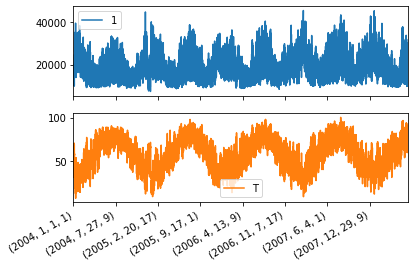

In [87]:
temp[[1, 'T']].plot(subplots=True)

In [88]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(temp[[1, 'T']])

# Using 80% of data for training, 20% for validation.
TRAINING_PERCENT = 0.80

train_size = int(len(scaled) * TRAINING_PERCENT)
test_size = len(scaled) - train_size
train_multi, test_multi = scaled[0:train_size, :], scaled[train_size:len(scaled), :]
print("Number of samples training set: " + str((len(train_multi))))
print("Number of samples test set: " + str((len(test_multi))))

Number of samples training set: 31660
Number of samples test set: 7916


In [89]:
def create_dataset_nstep_multi(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - nstep - 1):
        sample = dataset[i:(i + window_size), :]
        data_x.append(sample)
        data_y.append(dataset[(i + window_size):(i + window_size + nstep), 0])
    return(np.array(data_x), np.array(data_y))

In [90]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (2, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 50
nstep = 1
train_X, train_Y = create_dataset_nstep_multi(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep_multi(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[2], train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[2], test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26866 samples, validate on 4742 samples
Epoch 1/100
 - 5s - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0361 - val_loss: 9.8162e-04 - val_mean_squared_error: 9.8162e-04 - val_mean_absolute_error: 0.0239
Epoch 2/100
 - 3s - loss: 6.5035e-04 - mean_squared_error: 6.5035e-04 - mean_absolute_error: 0.0192 - val_loss: 6.4304e-04 - val_mean_squared_error: 6.4304e-04 - val_mean_absolute_error: 0.0189
Epoch 3/100
 - 2s - loss: 4.9880e-04 - mean_squared_error: 4.9880e-04 - mean_absolute_error: 0.0167 - val_loss: 5.0857e-04 - val_mean_squared_error: 5.0857e-04 - val_mean_absolute_error: 0.0165
Epoch 4/100
 - 3s - loss: 4.1988e-04 - mean_squared_error: 4.1988e-04 - mean_absolute_error: 0.0152 - val_loss: 4.7597e-04 - val_mean_squared_error: 4.7597e-04 - val_mean_absolute_error: 0.0162
Epoch 5/100
 - 2s - loss: 3.7865e-04 - mean_squared_error: 3.7865e-04 - mean_absolute_error: 0.0144 - val_loss: 3.9658e-04 - val_mean_squared_error: 3.9658e-04 - val_mean_absolute_err

In [91]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (2, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 100
nstep = 1
train_X, train_Y = create_dataset_nstep_multi(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep_multi(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[2], train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[2], test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26824 samples, validate on 4734 samples
Epoch 1/100
 - 5s - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0351 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0247
Epoch 2/100
 - 2s - loss: 8.1269e-04 - mean_squared_error: 8.1269e-04 - mean_absolute_error: 0.0217 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0284
Epoch 3/100
 - 2s - loss: 5.9710e-04 - mean_squared_error: 5.9710e-04 - mean_absolute_error: 0.0184 - val_loss: 9.8194e-04 - val_mean_squared_error: 9.8194e-04 - val_mean_absolute_error: 0.0255
Epoch 4/100
 - 2s - loss: 5.2769e-04 - mean_squared_error: 5.2769e-04 - mean_absolute_error: 0.0174 - val_loss: 6.7101e-04 - val_mean_squared_error: 6.7101e-04 - val_mean_absolute_error: 0.0199
Epoch 5/100
 - 2s - loss: 4.6346e-04 - mean_squared_error: 4.6346e-04 - mean_absolute_error: 0.0162 - val_loss: 4.5102e-04 - val_mean_squared_error: 4.5102e-04 - val_mean_absolute_error: 0.0158
Epoch

In [46]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (2, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 50
nstep = 24
train_X, train_Y = create_dataset_nstep_multi(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep_multi(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[2], train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[2], test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26847 samples, validate on 4738 samples
Epoch 1/100
 - 6s - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0773 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0614
Epoch 2/100
 - 4s - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0511 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0568
Epoch 3/100
 - 3s - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0488 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0555
Epoch 4/100
 - 2s - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0481 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0550
Epoch 5/100
 - 2s - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0475 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0551
Epoch 6/100
 - 3s - loss: 0.0042 - mean_squared_error: 0.0042

In [47]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (2, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 200
nstep = 24
train_X, train_Y = create_dataset_nstep_multi(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep_multi(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[2], train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[2], test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26719 samples, validate on 4716 samples
Epoch 1/100
 - 5s - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0726 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0637
Epoch 2/100
 - 3s - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0511 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0579
Epoch 3/100
 - 3s - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0487 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0547
Epoch 4/100
 - 3s - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0474 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0541
Epoch 5/100
 - 3s - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0469 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0534
Epoch 6/100
 - 3s - loss: 0.0040 - mean_squared_error: 0.0040

In [48]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (2, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 200
nstep = 24*7
train_X, train_Y = create_dataset_nstep_multi(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep_multi(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[2], train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[2], test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26597 samples, validate on 4694 samples
Epoch 1/100
 - 5s - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0860 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0806
Epoch 2/100
 - 3s - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0688 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0816
Epoch 3/100
 - 3s - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0679 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0805
Epoch 4/100
 - 3s - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0675 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0791
Epoch 5/100
 - 3s - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0671 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0812
Epoch 6/100
 - 3s - loss: 0.0080 - mean_squared_error: 0.0080

In [49]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (2, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 500
nstep = 24*7
train_X, train_Y = create_dataset_nstep_multi(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep_multi(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[2], train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[2], test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26342 samples, validate on 4649 samples
Epoch 1/100
 - 6s - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0860 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0819
Epoch 2/100
 - 3s - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0681 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0808
Epoch 3/100
 - 3s - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0669 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0813
Epoch 4/100
 - 3s - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0664 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0796
Epoch 5/100
 - 3s - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0659 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0827
Epoch 6/100
 - 3s - loss: 0.0076 - mean_squared_error: 0.0076

In [93]:
vanilla_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 20)                9680      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 21        
Total params: 9,701
Trainable params: 9,701
Non-trainable params: 0
_________________________________________________________________
